# Creating a CNN for MNIST with Keras
CNNs or Convolutional Neural Networks are a special type of neural network which is particularly adept for computer vision problems. CNNs get their name from convolutions in mathematics which represent a relationship between two functions. CNNs are also inspired by the visual cortex of the brain.
https://en.wikipedia.org/wiki/Convolutional_neural_network#Building_blocks

MNIST is a well-known dataset for handwritten digit recognition. It is a popular benchmark for beginning machine learning. 
Data readily available through Kaggle:
https://www.kaggle.com/c/digit-recognizer/data
Additional benchmarks provided by Yann LeCun and friends:
http://yann.lecun.com/exdb/mnist/

Keras is an emerging framework that abstracts Tensorflow and Theano. While these two frameworks abstract the algorithms and hardware for deep learning, Keras abstracts their "language" into one that is much closer to a natural language of deep learning.
http://keras.io

Today we will be going through our friend's example over at machinelearningmastery.com
http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/



## Visualizing the data
Before we get started, let's look at the data. The original tutorial provides a nice visualization of the dataset.

In [1]:
# To make this work in a notebook, we need the following:
%matplotlib inline

# Import as usual
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


Here we download the dataset. This may take a few seconds:

In [2]:
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

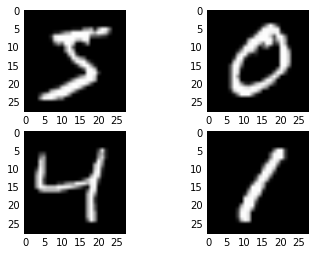

In [3]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Now that we know what we're looking at, let's begin!

## Multi-Layer Perceptron as a Baseline

Before we build the convolutional neural net, it is wise for us to see how a much simpler model performs. To do so, we will use a multi-layer perceptron model.

### Pre-processing for the multi-layer perceptron

The next few steps will setup our script and our data.

In [4]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

The authors are good about setting the random seed in their demos. +1 for repeatable research!

In [5]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Since everything is in one notebook, we don't need to reload the data. I'll keep this here but comment it out.

In [6]:
# load data
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

Our test set comes in an intuitive format for humans a 3D array (image X width X height) but the input layer of our model is going to work on a "rolled-out" vector of each image. This is where NumPy comes in handy:

In [7]:
# flatten 28*28 images to a 784 vector for each image

# Shape tells us the current shape (the array dims which are also our image dims)
num_pixels = X_train.shape[1] * X_train.shape[2]

# Reshape takes the "new shape" then we set the type to 32-bit float before assignment
# So our new shape is 1Xnum_imagesXnum_pixels
# The result is a 2D array of [num_images, num_pixels]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
# Repeat for test set
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

Now we have our data in the structure we want. The original authors perform normalization which is common. The process is simple, conform a set of values of some range to one of range 0-1. https://en.wikipedia.org/wiki/Normalization_(statistics)

As the authors at KDNuggets point out, this may only be important if the input features are of differing scales. This step of normalization is part of a "pre-processing" step which is necessary for almost any machine learning project. Other techniques include zero-centering or PCA whitening. http://www.kdnuggets.com/2016/03/must-know-tips-deep-learning-part-1.html

However, it may not be such a bad idea to do it anyway: (1) so that we have them normalized, should we introduce more features (2) we develop the habit for when we build CNNs for other datasets.

In [8]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Additional pre-processing is needed on the labels of the dataset. More specifically, we have to determine what type of output we expect from our CNN. As the authors point out, this is a multi-class classification problem. It is common to assign one activation unit per class in the output layer which outputs on a 0-1 scale. This results in a binary encoded output AKA one-hot encoded outputs.

In [9]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Note that np_utils is part of Keras, not NumPy. https://keras.io/utils/np_utils/

From the documentation, we can see what to_categorical is doing:
"Convert class vector (integers from 0 to nb_classes) to binary class matrix, for use with categorical_crossentropy."

So to_categorical() is expecting a 1D set of integers (in this case, our labels) and converting it to a 2D matrix of binary classes. That's a lot of abstraction from the old days of converting ints to bytes!

Now that we have structured our inputs and outputs for a neural network. We can actually build the model.

### Building the Baseline Multi-Layer Perceptron Model

In Keras, we need to create a Sequential() object and make successive add() calls on that object to define the architecture of the network. We then need to "compile" the model which translates the architecture to the backend language (either TF or Theano). I won't go into as much detail about some Keras concepts as I did this with a previous tutorial from the same site. https://github.com/Shumakriss/MachineLearningTutorials/blob/master/Simple%20Neural%20Net%20in%20Keras.ipynb

I will, however, try to go into detail about any parameter selections I have not used before.

This is a little different than the previous examples. Here we are creating a method to return the model. I find it interesting that this method returns a new instance of a model. While it may serve to clean up the code, as a software engineer, it does not make this method seem particularly useful. I could see tweaking it to be a \*gasp\* singleton in some cases.

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Above, we have a few new techniques:

* Normal Distribution - We use a normal distribution instead of a uniform distribution like in our Simple Neural Net example. Either example helps break symmetry (unlike zero-initialization). It seems that initializing weights from a normal distribution was fairly standard prior to Xavier initialization which has come to be widely used and which samples from either a uniform or a Gaussian distribution.
* Softmax Activiation - Previously we used relu and sigmoid activations. Softmax is a generalization of the logistic function (sigmoid) for multiple classes. More on Wikipedia https://en.wikipedia.org/wiki/Softmax_function#Artificial_neural_networks. I was wondering why we might want this since we have separate outputs for each class. It seems the answer is that we want to incorporate some "mutual exclusitivity" into the probability of each class. https://www.quora.com/Artificial-Neural-Networks-Why-do-we-use-softmax-function-for-output-layer. This helps us avoid situations where the probability of two or more classes being roughly the same.
* Categorical Cross-entropy as a loss function - In the Simple Neural Net example, we used a binary cross-entropy loss function. Wikipedia is not too helpful https://en.wikipedia.org/wiki/Loss_functions_for_classification#Cross_entropy_loss for purposes of deep-learning but does provide some comparison of statistical loss functions. The Keras documentation, on the other hand, does provide some insight based on the available options: https://keras.io/objectives/. From the Keras docs, we can see that we have some regression-based loss functions and some classification-based log functions and we can infer that categorical cross-entropy is the mathematical term for a statistical method of classification. The term 'categorical' simply serves to distinguish the function as multi-class as opposed to 'binary' meaning just two classes (0 or 1).

Other than these points, the rest of the Keras code for building a model is the same as in the Simple Neural Net example.

### Training and Evaluating the Multi-layer perceptron Model

After we define our model, we can call our function to initialize it. Once initialized, we can fit/train our model on our data. We will again set verbose=0 for the sake of our notebook. We will also set the argument validation_data to our test set. The Keras documentation says this will be used as data that will be held out. I would like to review this tutorial http://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ to understand the specifics around validation_data and how it fits into a rigorous evaluation method. It is not obvious from the example and documentation how validation_data is used during training or if it is mathematically sound to use the same data in validation_data as the evaluate() data. Since this might be due to the quick-and-dirty nature of the baseline, I will save that for another day.


In [11]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=0)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 1.80%


## Convolutional Neural Network
Now for the good stuff. We can begin working with CNNs in Keras.

### Imports and Setup for CNN
I want to keep this all in one notebook. For that reason, I will be removing some imports we have already incorporated. I am also commenting out the line where we set the image_dim_ordering to "th". This is to configure Theano for a backend, at least with regard to how image dimensions are specified. Since I have tensorflow installed on my machine and configured in a Keras config file, I will simply omit this line.

In [12]:
# Since this is the same code, we don't need all the imports from the original tutorial
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
# Uncomment if you do not have a Keras config file
# Pass 'th' for Theano backend or 'tf' for Tensorflow, be sure to have the correct one installed
# K.set_image_dim_ordering('th')

Again, commenting unecessary lines as we are in a single project.

In [13]:
## fix random seed for reproducibility
#seed = 7
#numpy.random.seed(seed)

I do want to reset any changes we might have made to the training or test sets. 

In [14]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Pre-processing for CNN
This time, we are going to be unrolling our images a bit differently. The original authors put it best, "Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].

In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1."

To paraphrase, typical CNNs (which work on images) expect an RGB format. So in addition to the number of images and the image dimensions, we also want to know how many channels are involved. But MNIST are in grayscale, we only need one dimension. This results in a list of pixel values in the same order but are technically grouped with an extra dimension. Later, when the convolution looks at the shape of the object, it will still have the "channel" dimension it is expecting even though it is only of value 1.

In [15]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

Again, some pre-processing is needed:

In [16]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

### Defining the CNN Model
I really appreciate that the original authors utilize components for state-of-the-art (SOTA) results. This way, we can see a realistic example and expand on familiar concepts.

I will also defer to the original authors for a summary of their CNN as it is fairly detailed but concise:
>1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
>2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
>3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
>4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
>5. Next a fully connected layer with 128 neurons and rectifier activation function.
>6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

Let me translate (with lots of help):
1. CNNs can be thought of as a sliding window across an image (which actually occurs in parallel) where different portions of the image are fed to later hidden layers. So in effect, these later hidden layers are effectively learning some feature(s) of the image but across different portions of the image. In this case, that sliding window is of size 5X5 and we use 32 of them in total. The sliding window is actually handled by the convolutional layer which in this case is also our input layer, although more convolutional layers can be applied. For more on feature maps see https://www.quora.com/What-is-meant-by-feature-maps-in-convolutional-neural-networks. For more on convolutions see https://youtu.be/C_zFhWdM4ic.
2. Pooling layers are effectively downsampling the image. This can improve convergence time as well as reduce overfitting. Intuitively, pooling happens once we know some features exist and where they are relative to each other, we do not need to preserve any more of the original data. See also http://cs231n.github.io/convolutional-networks/#pool and https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer.
3. Dropout is a regularization technique. If you are new to machine learning, recall that regularization is a term for smoothing a function. This may lead to a lower training accuracy but is said to "generalize" better on test, validation, and real data. To better understand dropout, we should understand "ensembling" and "bagging". Imagine we have a few neural networks each trained on a subset of data that we average together. The use of multiple nets is known as "ensembling" while the specific use of subsetting the data and averaging the nets is known as "bagging". Dropout as a regularization technique, approximates this ensembling approach by changing the way the weights are changed during training. In each step of training, units are randomly removed while backprop occurs as usual with the effect of training multiple smaller networks on a subset. https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning.
4. Since the layers to this point operate in a higher dimensional space and we want a classifier in 1 dimension, we use a technique called flattening. https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network.
5. Another hidden layer is added, presumably this serves to improve performance of the network.
6. The output layer needs to align to our classification problem (10 units for 10 classes).

In [17]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Other than the CNN components, nothing new is introduced. So we can now train and evaluate the model. This will take some time on a laptop. The original authors say this might take about 15 minutes.

In [18]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=0)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
80s - loss: 0.2457 - acc: 0.9301 - val_loss: 0.0758 - val_acc: 0.9767
Epoch 2/10
80s - loss: 0.0731 - acc: 0.9781 - val_loss: 0.0498 - val_acc: 0.9848
Epoch 3/10
79s - loss: 0.0521 - acc: 0.9842 - val_loss: 0.0408 - val_acc: 0.9863
Epoch 4/10
78s - loss: 0.0420 - acc: 0.9868 - val_loss: 0.0377 - val_acc: 0.9871
Epoch 5/10
78s - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0389 - val_acc: 0.9864
Epoch 6/10
78s - loss: 0.0277 - acc: 0.9913 - val_loss: 0.0398 - val_acc: 0.9874
Epoch 7/10
78s - loss: 0.0243 - acc: 0.9925 - val_loss: 0.0361 - val_acc: 0.9874
Epoch 8/10
78s - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0333 - val_acc: 0.9894
Epoch 9/10
80s - loss: 0.0165 - acc: 0.9949 - val_loss: 0.0402 - val_acc: 0.9881
Epoch 10/10
79s - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0337 - val_acc: 0.9892
Baseline Error: 1.08%


We can definitely see an improvement in our error. While this is a good amount of work and a longer training time, a nearly 1% boost can be an incredible improvement for many applications. But the authors are not satisfied yet. We can build an even better model!

## Larger CNN

Building on the last CNN model, we can increase the size of the net a bit more. 

### Preprocessing for a larger CNN

All of the imports are the same but we need to reset our data and pre-process it. This is certainly not the most efficient way of doing things on a large dataset but for MNIST this should be fine. The real computation and time cost comes during training of the model.

In [19]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
 
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

### Defining the larger CNN model

Recall our earlier model:

1. Convolutional layer with 32 feature maps of size 5×5
2. Pooling layer taking the max over 2×2 patches
3. Dropout layer with a probability of 20%
4. Flatten layer
5. Fully connected layer with 128 neurons and rectifier activation function
6. Output layer

In this larger model, we have 3 more layers. We add an additional convolutional and pooling layer after the first two layers this time with fewer and smaller feature maps. We also add an additional fully connected (dense) layer between the original dense layer and the output layer.

1. Convolutional layer with 30 feature maps of size 5×5
2. Pooling layer taking the max over 2*2 patches
3. Convolutional layer with 15 feature maps of size 3×3
4. Pooling layer taking the max over 2*2 patches
5. Dropout layer with a probability of 20%
6. Flatten layer
7. Fully connected layer with 128 neurons and rectifier activation
8. Fully connected layer with 50 neurons and rectifier activation
9. Output layer

In [20]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Caution: This model can take quite awhile to run.

In [21]:
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=0)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 0.78%


### Results of Larger CNN

How did it do? Amazingly! Less than 1% error on a laptop CPU with a few minutes of training? Incredible.